# Тема 06. Перенос обучения. Векторные представления изображений.

Нейронные сети большие и сложные. Чтобы хорошо обучить нейронную сеть нужно много времени, много релевантных данных. Скажем, сети для распознавания изображений обучаются на миллионах примеров изображений с тысячами разных классов, что требует недели и месяцы рассчетов, если, конечно, у вас нет компьютера с сотней-другой графических ускорителей.

У меня нет, а у вас? Что же, нам бросить заниматься нейронными сетями?

Оказывается, мы можем использовать чужие результаты, чтобы обучать, точней дообучать, нейронные сети для своих задач. 

Такой подход назвали **перенос обучения** (transfer learning). Раньше, пока к делу не подключились крупные компании, даже были фирмы которые продавали обученные слои нейронной сети ("слои свежие, подходи покупай"), но, к счастью, теперь огромное количество уже хорошо обученных нейронных сетей доступны бесплатно всем желающим.  

Вспомним, как работает сеть для классификации изображений с прошлого занятия. Изображение проходит несколько раз через сверточные слои, активацию, другие слои (например, dropout), а затем, через полносвязный слой (обычно с softmax), который и расчитывает уровни уверенности для классов.

Полносвязный слой это ведь обычная линейная регрессия. Значит все предыдущие слои так преобразовывали изображение, что оказалось достаточно линейной регрессии чтобы посторить классификатор. Но конечно, у нас это не получилось бы, если б мы пытались применить линейную регрессию сразу к изображению. 

Можно сказать, что промежуточные слои это некоторые преобразователи, а последний слой - классификатор.

Но абсолютно теми же самыми рассуждениями можно придти к выводу, что классификатор это поледние два слоя, а остальные - преобразователь. Или три...

Если мы имеем хорошо обученную нейронную сеть, то слои преобразователя хороши, они ведь позволяют потом построить классификатор.

А давайте возьмем "хороший" преобразователь от уже кем-то обученной сети (многие компании и ученые дают нам такие сети). А классификатор сделаем свой, для нашей задачи. Получится, что мы как бы отрезали последние слои у сети и заменили их на свои (рис.).

И уже эту сеть, с обученным преобразователем, но еще не обученным классификатором, будем обучать. Тут можно как зафиксировать и не обучать слои от преобразователя (быстрота), так и продолжить их обучение вместе со слоями классификатора (точность). 

![img](https://drive.google.com/uc?id=1bQubJ7HR9_7jT4RiVBCK4ttkuslO9jB8)


Вы решаете какие слои брать для преобразователя, какие для классификатора. Часто бывает так, что достаточно поменять лишь один последний слой.

На любом слое мы получаем некоторые карты признаков, и можем их использовать для классификатора. Мы **перенесли** обученные слои одной сети в другую.

Если нам надо обучить сеть распознавать изображения классов, которые никто не знает и не обучал, то нам нет необходимости делать это с нуля. Возьмем сеть, уже обученную распознавать большое число классов [ILSVRC](http://www.image-net.org/challenges/LSVRC/), и заменим в ней слои классификатора так, чтобы получались наши классы. И будем обучать уже такую составную сеть на новых примерах классов изображений.


## Пример

Давайте возьмем обученную сеть для классификации на  1000 классов [VGG16](https://arxiv.org/pdf/1409.1556.pdf) которая [победила в соревновании ImageNet в 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), и используем ее слои для классификации других классов изображений.

Мы загрузим VGG16, удалим последний ее слой (1000 нейронов с softmax) и заменим его на свой (97 нейронов и классов). Мы зафиксируем веса всех слоев, кроме последнего, т.е. не будем их обучать.

Сравним этот подход с попыткой обучить маленькую нейронную сеть с нуля. 

В нашем примере мы используем набор данных из 6000 изображений с 97 классами.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%matplotlib inline
# подключаем библиотеки 
import os
import random
import numpy as np
import keras # для нейронных сетей

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image # преодобработка изображений
from keras.applications.imagenet_utils import preprocess_input # преодобработка изображений для набора данных imagenet
from keras.models import Sequential # последовательное соединение слоев нейронной сети
from keras.layers import Dense, Dropout, Flatten, Activation # слои, которые будем использовать
from keras.layers import Conv2D, MaxPooling2D # слои, которые будем использовать
from keras.models import Model # объект нейронной сети в который собираются слои

Using TensorFlow backend.


### Загрузка набора данных

Мы используем набор данных [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), который отличается от ImageNet. Он содержит около 9000 размеченных изображений в 101 классе (в архиве файле есть еще 102ой класс с разными случайными картинками из интернета, но он нам не нужен). Мы исключим 5 классов с наибольшим числом изображений (включая 102ой), чтобы иметь классы с примерно одинаковым числом изображений в каждом (50-100), останется около 6000 изображений в 97 классах. Архив с данными хранится на нашем гугл-диске, чтобы скачать его оттуда используем  библиотеку `gdown`.

Если вы захотите обучать на своих классах, то должны сделать набор данных по аналогии с этим, где каждый класс хранится в поддиректориях, названия которых и определяют название классов. `root` - диерктория наборра данных. Вспомогательная функция  `get_image(path)` загружает изображение и масштабирует его к размеру 224x224, чтобы подходило для VGG16.

In [3]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz' # адрес
output = '101_ObjectCategories.tar.gz' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем


Downloading...
From: https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz
To: /content/101_ObjectCategories.tar.gz
132MB [00:02, 48.0MB/s]


'101_ObjectCategories.tar.gz'

In [4]:

!echo "Downloading 101_Object_Categories for image notebooks"
# распаковываем
!tar -xzf 101_ObjectCategories.tar.gz
# удаляем после распаковки
!rm 101_ObjectCategories.tar.gz
!ls


101_ObjectCategories  sample_data


In [5]:
root = '101_ObjectCategories' # директория с файлами
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces'] # классы, которые исключаем
train_split, val_split = 0.7, 0.15 # доли данных для обучения и проверки

# проходим по всем поддиректориям, они и есть наши классы
categories = [x[0] for x in os.walk(root) if x[0]][1:]
# но исключим некоторые из них
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
# посмотрим на классы. Специально оставили в названиях и общее название набора данных, чтобы не перепутать с другими
print(categories)

['101_ObjectCategories/joshua_tree', '101_ObjectCategories/chandelier', '101_ObjectCategories/starfish', '101_ObjectCategories/dragonfly', '101_ObjectCategories/okapi', '101_ObjectCategories/stegosaurus', '101_ObjectCategories/cellphone', '101_ObjectCategories/lamp', '101_ObjectCategories/Leopards', '101_ObjectCategories/octopus', '101_ObjectCategories/flamingo_head', '101_ObjectCategories/stapler', '101_ObjectCategories/garfield', '101_ObjectCategories/ferry', '101_ObjectCategories/bonsai', '101_ObjectCategories/mandolin', '101_ObjectCategories/lobster', '101_ObjectCategories/ibis', '101_ObjectCategories/accordion', '101_ObjectCategories/scissors', '101_ObjectCategories/gramophone', '101_ObjectCategories/llama', '101_ObjectCategories/umbrella', '101_ObjectCategories/menorah', '101_ObjectCategories/crocodile', '101_ObjectCategories/emu', '101_ObjectCategories/snoopy', '101_ObjectCategories/kangaroo', '101_ObjectCategories/brontosaurus', '101_ObjectCategories/ant', '101_ObjectCategories

In [6]:
# функция для загрузки изображения
def get_image(path):
    img = image.load_img(path, target_size=(224, 224)) # загружаем изображение и масштабируем
    x = image.img_to_array(img) # конвертируем в массив
    x = np.expand_dims(x, axis=0) # добавляем измерение (batch) 1*224*224*3
    x = preprocess_input(x) # предобработка 
    return img, x # возвращаем изображение PIL и массив для него

Загрузка всех изображений.

In [7]:
data = [] # пустой массив для данных
for c, category in enumerate(categories): # для всех классов, они же поддиректории
    # берем названия всех файлов в ней, объединяем с названием (путем к) самой директории,
    # но только такие, в которых расширение '.jpg','.png','.jpeg'. 
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    # для всех изображений класса
    for img_path in images:
        img, x = get_image(img_path) # загружаем его
        data.append({'x':np.array(x[0]), 'y':c}) # добавляем в словарь 'x' - массив изображения и 'y' - номер класса.

# число классов
num_classes = len(categories)

In [8]:
random.shuffle(data) # перемешаем случайно

Обучающее, тестовое и проверочное множества (70%, 15%, 15%)



In [9]:
idx_val = int(train_split * len(data)) # индекс начала для проверочного множества
idx_test = int((train_split + val_split) * len(data)) # индекс начала для тестового множества
# разделяем
train = data[:idx_val] #
val = data[idx_val:idx_test] #
test = data[idx_test:] #

In [10]:
# разделяем данные и метки в отдельные переменные
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[64, 92, 79, 5, 8, 5, 59, 7, 42, 59, 44, 91, 17, 44, 38, 84, 2, 37, 6, 55, 30, 11, 8, 67, 30, 3, 59, 42, 65, 10, 53, 15, 12, 39, 11, 47, 82, 46, 92, 92, 8, 13, 87, 38, 96, 68, 64, 14, 78, 7, 74, 77, 6, 53, 24, 35, 53, 17, 5, 49, 31, 61, 94, 50, 67, 6, 16, 56, 8, 19, 41, 88, 64, 89, 59, 43, 53, 61, 65, 68, 93, 2, 47, 21, 9, 3, 67, 77, 87, 52, 67, 53, 23, 70, 11, 64, 81, 17, 90, 23, 55, 54, 58, 31, 55, 77, 31, 87, 84, 91, 22, 56, 74, 94, 93, 91, 52, 9, 29, 30, 33, 81, 76, 46, 66, 32, 39, 38, 55, 55, 64, 38, 55, 15, 78, 91, 30, 53, 17, 10, 20, 42, 86, 88, 3, 56, 80, 51, 36, 6, 85, 0, 24, 8, 13, 57, 45, 90, 16, 8, 62, 82, 60, 57, 10, 18, 2, 85, 69, 20, 71, 41, 33, 12, 84, 70, 81, 92, 79, 28, 6, 96, 24, 47, 89, 86, 24, 31, 88, 47, 8, 3, 77, 37, 78, 80, 6, 86, 17, 82, 15, 5, 50, 47, 73, 50, 43, 14, 64, 21, 1, 41, 61, 17, 17, 2, 45, 7, 49, 80, 14, 50, 63, 8, 4, 23, 30, 17, 52, 50, 72, 42, 74, 55, 47, 55, 59, 7, 80, 15, 43, 55, 9, 89, 52, 73, 55, 90, 25, 56, 66, 84, 91, 59, 71, 55, 42, 18, 57,

Предобработка, перевод в float32 и нормализация к 0...1. Кодирование классов.

In [11]:
# нормализация
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# конвертируем номера классов в one-hot вектора
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Что у нас получилось:

In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Если все правильно, то должен получиться набор изображений, разделенный на `train`, `val` ,и `test`. Размер данных (`n`, 224, 224, 3) где `n` число примеров, указания учителя (`n`, `c`) где `c` - число классов (97 в нашем примере `101_ObjectCategories`). 


Посмотрим на некоторые изображения.

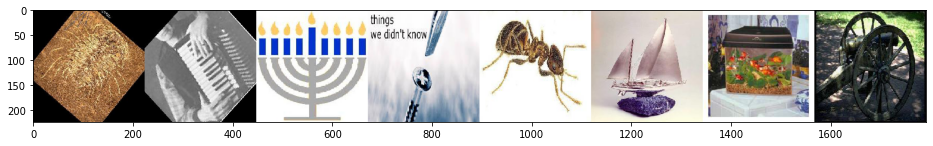

In [13]:
# названия всех изображений
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
# выбираем случайно 8 штук 
idx = [int(len(images) * random.random()) for i in range(8)]
# загружаем эти изображения
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
# объединяем в одну строку 
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
# рисуем
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Обучение нейронной сети с нуля

Эта нейронная сеть будет состоять из 4 сверточных слоев и max-pooling, со слоем [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) после каждых двух слоев свертки\пулинга. Затем подключаем полносвязный слой с 256 нейронами, еще слой dropout, и, наконец, полносвязный слой с softmax для классификации (а сколько в нем нейронов?).

Функцию ошибки возьмем кросс-энтропию, метод обучения Adam.

Вы можете поменять параметры.

In [14]:
# создаем нейронную сеть
model = Sequential() # последовательное подключение слоев
print("Input dimensions: ",x_train.shape[1:]) # размер входа

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:])) #  свертка
model.add(Activation('relu')) # активация
model.add(MaxPooling2D(pool_size=(2, 2))) # пулинг

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25)) # dropout

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten()) # вытягиваем результаты сверток в вектор 
model.add(Dense(256))# полносвязный слой
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes)) # полносвязный слой классификации
model.add(Activation('softmax')) # активация softmax

model.summary() # напечатаем информацию о сети

Input dimensions:  (224, 224, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_____

Мы получили сеть в которой ~1.2 million весов и смещений, большинство из них в первом полносвязном слое.

Будем обучать нашу модель 20  эпох (поменяйте) с пакетом размера 128. Будем записывать историю. 

In [15]:
# компилируем модель и указываем опции обучения
model.compile(loss='categorical_crossentropy', #  функция ошибки
              optimizer='adam', # метод обучения
              metrics=['accuracy']) #  измеряемые метрики
# обучаем модель
history = model.fit(x_train, # примеры входа
                    y_train, # указания учителя
                    batch_size=128, # размер пакета
                    epochs=20, # количество эпох 
                    validation_data=(x_val, y_val)) #  данные для проверки



Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 16s 4ms/step - loss: 4.5205 - accuracy: 0.0403 - val_loss: 4.4237 - val_accuracy: 0.0591
Epoch 2/20
4346/4346 [==============================] - 6s 1ms/step - loss: 4.2965 - accuracy: 0.0828 - val_loss: 4.1273 - val_accuracy: 0.1364
Epoch 3/20
4346/4346 [==============================] - 6s 1ms/step - loss: 3.9007 - accuracy: 0.1641 - val_loss: 3.6596 - val_accuracy: 0.2277
Epoch 4/20
4346/4346 [==============================] - 6s 1ms/step - loss: 3.4824 - accuracy: 0.2301 - val_loss: 3.2895 - val_accuracy: 0.2803
Epoch 5/20
4346/4346 [==============================] - 6s 1ms/step - loss: 3.1178 - accuracy: 0.2895 - val_loss: 3.0497 - val_accuracy: 0.3244
Epoch 6/20
4346/4346 [==============================] - 6s 1ms/step - loss: 2.8044 - accuracy: 0.3422 - val_loss: 2.8605 - val_accuracy: 0.3813
Epoch 7/20
4346/4346 [==============================] - 6s 1ms/step - loss: 2.4882 - ac

Построим графики для функции ошибки и метрики аккуратности на проверочных данных.

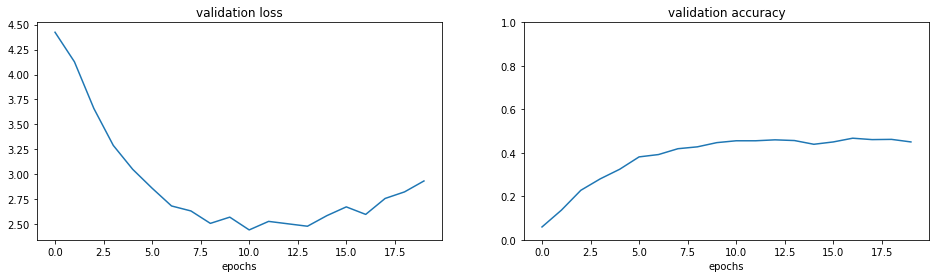

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"]) # функция ошибки
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) # метрика аккуратности
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Получили что-то около 40-50% аккуратности. Врядли она возрастет существенно, попытайтесь. 

Проверим на тестовых данных.

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) # проверяем на тестовых данных
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.0214832514652366
Test accuracy: 0.44098711013793945


Итак, аккуратность около 50%. Не так плохо, но и не так хорошо. Для 97 классов, если бы мы случайно угадывали бы класс, получили бы что-то около 1% аккуратности. 

# Используем предобученную сеть

Теперь сделаем тоже самое, но будем использовать уже обученную сеть, а заменим только слои для классификации. 

In [18]:
# обученная сеть
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary() # ее описание

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Эта сеть, VGG16, _гораздо_ больше нашей. Содержит 13 сверточных слоев, два полносвязных и более 138 миллионов обучаемых параметров, что почти в 100 раз больше чем было у нас. 

VGG16 обучалась на ImageNet и показала [8.8% top-5 ошибку](https://github.com/jcjohnson/cnn-benchmarks), это значит что 91.2% тестовых примеров были классифицированы правильно и верные классы входили в top 5 самых уверенных. top-1 аккуратность около 73%. И при этом в ней не 97, а 1000 классов (случайное угадываение дало бы 0.1% аккуратности).

Чтобы использовать такую сеть мы "отрежем" последний слой с 1000 нейронами (которые отвечают за 1000 классов ImageNet) и заменим его на слой с 97 нейронами для нашего набора данных. 

Технически мы не будем ничего отрезать, а сделаем копию слоев VGG до предпоследнего. Используем класс `Model` чтобы создать сеть, объединяя вход VGG, и слои VGG до предпоследнего с новым слоем, названного `new_classification_layer`. Мы возьмем выход предпоследнего слоя VGG и подадим его на новый слой. Не беспокойтесь что при копировании мы тратим память, Keras просто ссылается на нужные места и фактически ничего не копируется.

In [19]:
# ссылка на вход VGG
inp = vgg.input

# новый полносвязный слой классификации с softmax и num_classes нейронов
new_classification_layer = Dense(num_classes, activation='softmax')

# подключаем новый слой к предпоследнему слою VGG (индекс -2), и делаем ссылку на него
out = new_classification_layer(vgg.layers[-2].output)

# создаем сеть от входа до нового выхода. 
model_new = Model(inp, out)


Мы будем обучать эту сеть `model_new` на новых изображениях и классах, но мы заморозим (зафиксируем) веса и смещения у всех слоев, кроме нового последнего и будем обучать только последний слой. Устанавливаем флаг `trainable` в false. Если время и ресурсы позволяют, можете обучать и всю сеть целиком. 

В качестве упражнения разрешите обучать также веса предпоследнего слоя.

In [20]:
# запрещаем обучение всех весов\смещений для слоев кроме последнего
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# на всякий случай последнему слою разрешаем обучаться
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# компилируем модель и указываем опции обучения
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary() # печатаем информацию о модели

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Получили сеть похожую на VGG, кроме последнего слоя, имеем 134 миллиона параметров, но обучаемых среди них только 397 тысяч, что в 4 раза меньше чем в прошлой сети.

Обучаем.

In [21]:
# обучаем
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=20, 
                         validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 46s 11ms/step - loss: 4.0991 - accuracy: 0.1687 - val_loss: 3.1033 - val_accuracy: 0.3072
Epoch 2/20
4346/4346 [==============================] - 26s 6ms/step - loss: 2.5478 - accuracy: 0.4581 - val_loss: 2.3206 - val_accuracy: 0.4844
Epoch 3/20
4346/4346 [==============================] - 26s 6ms/step - loss: 1.9438 - accuracy: 0.5686 - val_loss: 1.9702 - val_accuracy: 0.5349
Epoch 4/20
4346/4346 [==============================] - 26s 6ms/step - loss: 1.6144 - accuracy: 0.6415 - val_loss: 1.6562 - val_accuracy: 0.6241
Epoch 5/20
4346/4346 [==============================] - 26s 6ms/step - loss: 1.3935 - accuracy: 0.6889 - val_loss: 1.4560 - val_accuracy: 0.6874
Epoch 6/20
4346/4346 [==============================] - 26s 6ms/step - loss: 1.2629 - accuracy: 0.7119 - val_loss: 1.4717 - val_accuracy: 0.6391
Epoch 7/20
4346/4346 [==============================] - 26s 6ms/step - loss: 1.132

Аккуратность около 80%, что  на 30-40% больше, чем ранее. Проверьте, а быстрей ли эта сеть или нет.

Построим графики (оранжевая - новая сеть).

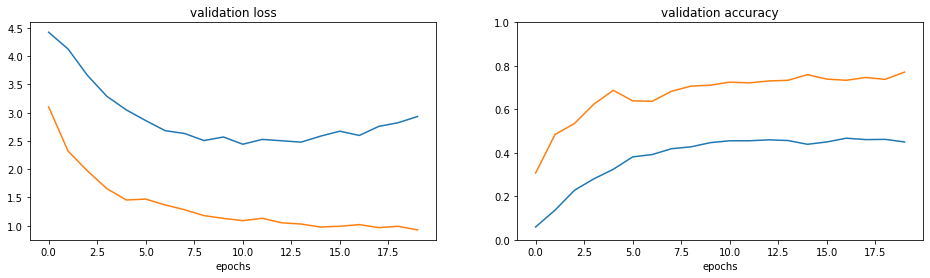

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"]) # функция ошибки предыдущей сети
ax.plot(history2.history["val_loss"]) # функция ошибки этой сети
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) # аккуратность предыдущей сети
ax2.plot(history2.history["val_accuracy"]) # аккуратность этой сети
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Проверим на тестовых данных.

In [23]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0501083747000142
Test accuracy: 0.7360514998435974


Для работы с новыми изображениями рассчитайте уровни уверенности классов, выберите максимальный.

101_ObjectCategories/chair 0.9773515


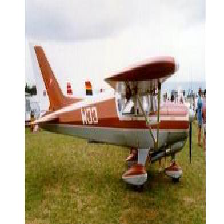

In [24]:
img, x = get_image('101_ObjectCategories/airplanes/image_0009.jpg')
probabilities = model_new.predict([x])
id=np.argmax(probabilities)
print(categories[id],probabilities[0,id])
img

Вопрос, а почему в примере выше вы никогда не получите правильный класс airplanes?

# Векторные представления изображений
Как мы убедились, информация, содержащаяся в промежуточных слоях хорошо обученных нейронных сетей, достаточна для классификации изображений. Это значит, что мы можем заменить изображение этой информацией и работать с ней. Например с предпоследнего слоя получается некоторый вектор, значит можем исходное изображение представить (описать) этим вектором.

Получили векторное представление изображения. Эти вектора не банальны, их достаточно чтобы классифицировать изображения, значит в них установлены какие-то важные взаимосвязи между пикселями изображения. 

А давайте такие вектора кластеризуем. Не окажется ли так, что они группируются в "похожие" группы. В 10 классе мы познакомились с методами главных компонент PCA и T-SNE, давайте с их помощью отобразим вектора изображений в двумерное пространство.

![img](https://drive.google.com/uc?id=19U3gdTfOYzZBbTiqdmEwU0PEOmfHn-rh)

Возьмем уже обученную сеть (здесь ResNet50).

Пропустим через нее изображение. И возвратим вектор, который получается перед классификатором (здесь выход с полносвязного слоя после слоя flatten, стрелка на рис.). Будем дальше работать с этими векторами.

Все эти операции уже реализованы в библиотеке [img2vec-keras](https://github.com/jaredwinick/img2vec-keras), установим ее.

Для сравнения векторов лучше подходит "косинусное расстояние" - косинус угла между ними, чем больше, тем похожей.  




Установим библиотеку и, если потребуется, после установки нажмите "Restart Runtime".

In [25]:
!pip install git+git://github.com/jaredwinick/img2vec-keras.git

  Cloning git://github.com/jaredwinick/img2vec-keras.git to /tmp/pip-req-build-uqd7afm2
  Running command git clone -q git://github.com/jaredwinick/img2vec-keras.git /tmp/pip-req-build-uqd7afm2
     |████████████████████████████████| 454.3MB 34kB/s 
     |████████████████████████████████| 6.0MB 36.6MB/s 
     |████████████████████████████████| 471kB 48.8MB/s 
  Created wheel for img2vec-keras: filename=img2vec_keras-0.2-cp37-none-any.whl size=6205 sha256=4f620ccd1b2a31aac76ff4c147b72189e287fbb1b1d6c71aacc4f8cef56aee4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-bq4c3244/wheels/2e/90/3e/18022740db56735624f1fa778b670e7c013bbf4e9b1802e764
Successfully built img2vec-keras
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing

In [1]:
from img2vec_keras import Img2Vec # подключаем библиотеку для векторных представлений

from IPython.display import Image

import glob # для работы с файлами 

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # похожесть по косинусному расстоянию.
from sklearn.decomposition import PCA # метод клавных компонент
from sklearn.manifold import TSNE # метод TSNE
from sklearn.preprocessing import StandardScaler # масштабирование, убирает среднее, единичный разброс.

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2


img2vec = Img2Vec() # инициализируем вектора, загрузится предобученная сеть.

102973440/102967424 [==============================] - 1s 0us/step


In [2]:
image_paths = []
image_classes = ['pizza', 'schooner', 'scissors', 'panda'] # выберем классы для отображения, проверьте с другими

# считываем пути к изображениям этих классов
for image_class in image_classes: 
  image_paths.extend(glob.glob('101_ObjectCategories/' + image_class + '/*.jpg')) # только .jpg

In [3]:
# сколько их
len(image_paths)

193

In [4]:
# создаем вектора для этих изображений
image_vectors = {}
for image_path in image_paths: # для каждого файла
  vector = img2vec.get_vec(image_path) # получаем векторное представление
  image_vectors[image_path] = vector # добавляем в словарь, название=ключ.

In [5]:
# массив только с векторами, размер вектора 2048
X = np.stack(list(image_vectors.values()))

In [6]:
pca_50 = PCA(n_components=50) #  первые 50 главных компонент
pca_result_50 = pca_50.fit_transform(X) # и проецируем на них
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

# 2 компоненты  TSNE   
tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50) # проецируем

Cumulative explained variation for 50 principal components: 0.8076638579368591
(193, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 193 samples in 0.002s...
[t-SNE] Computed neighbors for 193 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 193 / 193
[t-SNE] Mean sigma: 8.244461
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.076721
[t-SNE] KL divergence after 1450 iterations: 0.290262


In [7]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result) # масштабируем

Читаем изображения. Порядок такой же как при создании векторов, ведь как вы помните, TSNE работает только с теми векторами на которых и обучался, с другими не может.

In [8]:
# читаем изображения
images = []
for image_path in image_paths:
  image = cv2.imread(image_path, 3) # загружаем изображение
  b,g,r = cv2.split(image)           # разделяем каналы b, g, r
  image = cv2.merge([r,g,b])         # собираем в r, g, b
  image = cv2.resize(image, (50,50)) # масштаб
  images.append(image)        # добавляем в список



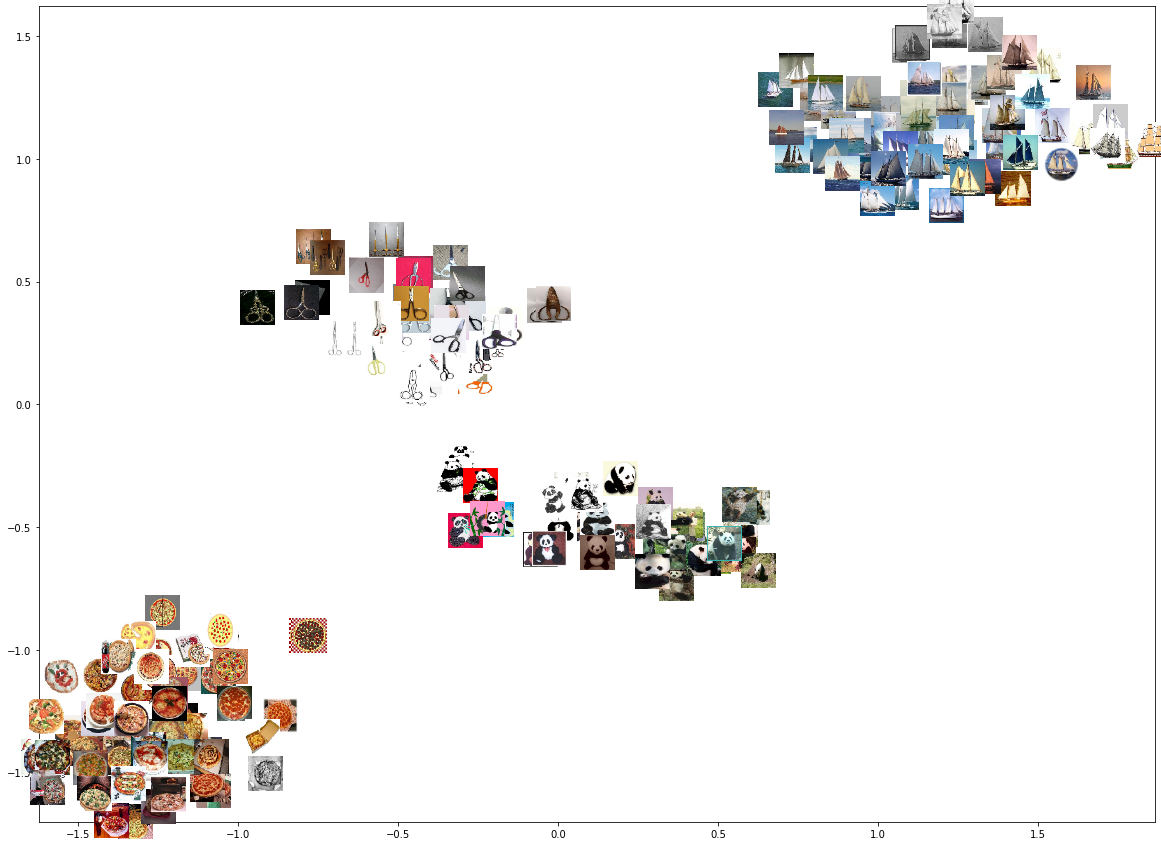

In [9]:
# рисуем
fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images): # перебираем TSNE вектора (это двумерные координаты) и изображения 
  x0, y0 = xy # разделяем горизонтальную и вертикальную координату
  img = OffsetImage(i, zoom=.7) # задаем графический объект с картинкой
  ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False) # вставляем эту картинку по координатам из вектора TSNE
  artists.append(ax.add_artist(ab)) # добавляем на график
ax.update_datalim(tsne_result_scaled) # пределы отображения
ax.autoscale(enable=True, axis='both', tight=True) # автомасштаб
plt.show() # отображаем

И действительно, видим, что похожие изображения собрались в группы. Установили, что у "похожих" изображений "похожие" вектора.

Векторное представление это очень мощный инструмент обработки изображений, теперь мы можем работать с векторами вместо самих изображений. Найти похожие изображения? Нет проблем, сравните их вектора по косинусному расстоянию. 

In [10]:
# путь к первому изображению
image_path1='101_ObjectCategories/Leopards/image_0001.jpg'
# его вектор, должен быть размером 1на2048 
vector1 = np.reshape(img2vec.get_vec(image_path1),(1,-1))

# путь ко второму изображению
image_path2='101_ObjectCategories/chair/image_0001.jpg'
# его вектор, должен быть размером 1на2048
vector2 = np.reshape(img2vec.get_vec(image_path2),(1,-1))

# их похожесть, чем больше тем похожей
similarity_matrix = cosine_similarity(vector1, vector2)

print(similarity_matrix)

[[0.2587084]]


Подробней с векторными представлениями мы познакомимся в теме про обработку текста.

# Ссылки
Использованы и адаптированы материалы:

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb 

https://github.com/jaredwinick/img2vec-keras

